In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from scipy.stats import rankdata, mannwhitneyu

In [3]:
data_files = ["new_experiments/"+str(i)+"_data.json" for i in range(8)]

combined_data = {}

for data_file in data_files:
    with open(data_file, 'r') as f:
        data = json.load(f)
        for key in data:
            if key not in combined_data:
                combined_data[key] = []
            combined_data[key]+= data[key]["coverages"]

for key in combined_data:
    with open("new_experiments/data_"+key+".json", 'w') as f:
        json.dump(combined_data[key], f)



In [4]:
combined_data = {}
keys = ["tlcstate", "random", "lineCov", "traceCov"]

for key in keys:
    with open("new_experiments/data_"+key+".json", 'r') as f:
        combined_data[key] = json.load(f)


In [5]:
plots = {
    "ModelFuzz": [],
    "Line": [],
    "Trace": [],
    "Random": []
}

key_maps = {"lineCov": "Line", "tlcstate": "ModelFuzz", "random": "Random", "traceCov": "Trace"}


for k in combined_data:
    avg = np.mean(combined_data[k], axis=0)
    std = np.std(combined_data[k], axis=0)
    plots[key_maps[k]] = [avg+0.2*std, avg-0.2*std, avg]

/var/folders/9h/9m7sztxs6fsd0k7wgvksdc4w0000gn/T/ipykernel_21423/3671682350.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(int(x/1000))+"k" for x in ax.get_xticks()])
/var/folders/9h/9m7sztxs6fsd0k7wgvksdc4w0000gn/T/ipykernel_21423/3671682350.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(int(y/1000))+"k" for y in ax.get_yticks()])


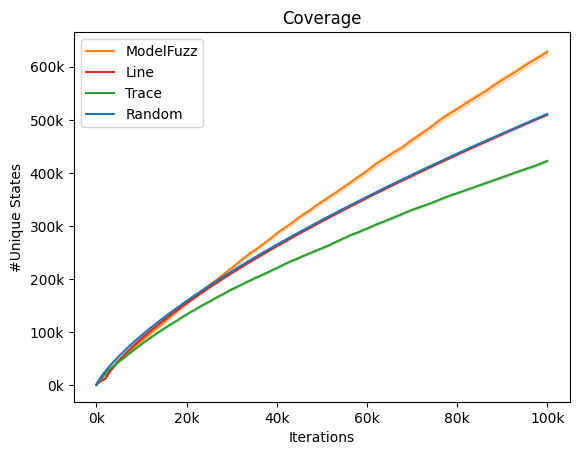

In [5]:
fig, ax = plt.subplots()

colors = {
    "ModelFuzz": "tab:orange",
    "Line": "tab:red",
    "Trace": "tab:green",
    "Random": "tab:blue"
}

for (b, bands) in plots.items():
    ax.plot(np.arange(len(bands[0])), bands[2], label=b, color=colors[b])
    ax.fill_between(np.arange(len(bands[0])), bands[0], bands[1], alpha=0.2, color=colors[b])

ax.set_xlabel('Iterations')
ax.set_ylabel('#Unique States')
ax.set_title("Coverage")
ax.legend()

# ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([str(int(x/1000))+"k" for x in ax.get_xticks()])
# ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([str(int(y/1000))+"k" for y in ax.get_yticks()])

# plt.show()
plt.savefig("etcd-compare-methods.pdf")

In [15]:
tlc_final_avg_cov = [cov[-1] for cov in combined_data["tlcstate"]]
for guidance, coverages in combined_data.items():
    if guidance == "tlcstate":
        continue
    g_cov = [cov[-1] for cov in coverages]
    print("{}\n{}".format(tlc_final_avg_cov, g_cov))
    u, p = mannwhitneyu(tlc_final_avg_cov, g_cov, alternative="greater")
    print("tlc vs {}: {}({})".format(guidance, u, p))

[608698, 615685, 588569, 632455, 614317, 611219, 649189, 604580, 628379, 707991, 633574, 668779, 582490, 652654, 622025, 602557, 604059, 675634, 628206, 613012, 605578, 612342, 652304, 654707]
[510639, 511574, 511834, 512300, 509167, 510372, 508731, 511774, 511253, 509875, 509193, 513044, 508915, 511620, 511491, 514434, 509141, 512708, 512355, 509301, 509954, 513502, 512059, 511268]
tlc vs random: 576.0(1.531832116836585e-09)
[608698, 615685, 588569, 632455, 614317, 611219, 649189, 604580, 628379, 707991, 633574, 668779, 582490, 652654, 622025, 602557, 604059, 675634, 628206, 613012, 605578, 612342, 652304, 654707]
[507609, 506573, 510168, 505107, 507017, 510974, 506471, 523578, 513960, 510163, 504830, 503350, 509081, 509723, 506326, 511140, 507710, 506030, 506977, 514095, 505471, 517312, 506966, 520512]
tlc vs lineCov: 576.0(1.531832116836585e-09)
[608698, 615685, 588569, 632455, 614317, 611219, 649189, 604580, 628379, 707991, 633574, 668779, 582490, 652654, 622025, 602557, 604059, 67

In [8]:
bugs = {}

with open("new_experiments/data_bugs.json", 'r') as f:
    buggy_executions = json.load(f)
    for cov_guidance in buggy_executions:
        bugs[cov_guidance] = {}
        for run, s in enumerate(buggy_executions[cov_guidance]["stats"]):
            for k in s["buggy_executions"]:
                iter = int(k.split("_")[1])
                if run not in bugs[cov_guidance]:
                    bugs[cov_guidance][run] = iter
                bugs[cov_guidance][run] = min(bugs[cov_guidance][run], iter)

# for run in range(20):
#     for cov_guidance in bugs:
#         if run not in bugs[cov_guidance]:
#             bugs[cov_guidance][run] = 1000

for cov_guidance in bugs:
    print("{}: {}({})".format(cov_guidance, int(np.mean(list(bugs[cov_guidance].values()))), len(list(bugs[cov_guidance].keys()))))



lineCov: 1342(19)
random: 599(20)
tlcstate: 1013(20)
traceCov: 940(20)


In [10]:
def ranksum(A:list, B:list, max_iters):
    # A and B are lists containing the first buggy iterations of all experiments for 2 different fuzzers
    data = A + B
    ranked_data = rankdata(list(map(lambda x: max_iters - x, data)))
    ranks = {}
    for i, d in enumerate(data):
        ranks[d] = ranked_data[i]
    return sum([ranks[e] for e in A])

def a_hat_12(A, B, max_iters):
    # m and n are the lenght of A and B
    m = len(A)
    n = len(B)
    return ((ranksum(A, B, max_iters) / m) - ((m+1) / 2)) / n

In [15]:

methods = ['tlcstate', 'traceCov', 'random', 'lineCov']
method_map = {
    'tlcstate': 'ModelFuzz',
    'traceCov': 'Trace',
    'random': 'Random',
    'lineCov': 'Line'
}

stats = {}
ci = 0.6
for key1, runs1 in bugs.items():
    rev_key1 = method_map[key1]
    if rev_key1 not in stats:
        stats[rev_key1] = {}
    for key2, runs2 in bugs.items():
        rev_key2 = method_map[key2]
        if key1 == key2:
            stats[rev_key1][rev_key2] = 0
            continue
        A = list(runs1.values())
        B = list(runs2.values())
        stat = a_hat_12(A, B, 2000)
        stats[rev_key1][rev_key2] = stat
    # data = runs.values()
    # if key == 'random':
    #     continue
    
    # A = list(bugs['random'].values())
    # B = list(data)

    # stat = a_hat_12(A, B, 2000)
    # stats[index] = {'A': 'Random', 'B': key, 'Statistic': stat, 'Significance': stat >= ci}
    # index += 1

df = pd.DataFrame(stats) # .T.sort_values('Random', ascending=True).reset_index(drop=True)
df

,Line,Random,ModelFuzz,Trace
Line,0.000000,0.602632,0.531579,0.557895
Random,0.397368,0.000000,0.430000,0.440000
ModelFuzz,0.468421,0.570000,0.000000,0.525000
Trace,0.442105,0.560000,0.475000,0.000000


In [15]:
bug_first_occurs = {
    "ModelFuzz": [],
    "Line": [],
    "Trace": [],
    "Random": []
}

easy_bugs = {}
hard_bugs = {}
with open("old_experiments/results_b_easy/data.json") as easy_f:
    easy_bugs = json.load(easy_f)
with open("old_experiments/results_b_hard/data.json") as hard_f:
    hard_bugs = json.load(hard_f)

for algo, d in easy_bugs.items():
    for b in d["stats"]:
        earliest = 1000
        for k, v in b["buggy_executions"].items():
            i = int(k[5:])
            if i < earliest:
                earliest = i
        bug_first_occurs[key_maps[algo]].append(earliest)

for algo, first_occurs in bug_first_occurs.items():
    print("{}: {} ({})".format(algo, len(first_occurs), np.mean(first_occurs)))

ModelFuzz: 5 (99.0)
Line: 5 (136.2)
Trace: 5 (101.6)
Random: 5 (279.6)
